In [60]:
from IPython import display
from IPython.core.display import Image


In [61]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  

In [62]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

In [63]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2023

&nbsp;
&nbsp;
&nbsp;
# Lab 4. Gaussian Processes

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Diabetes dataset

[Diabetes](https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset) is another classic benchmark for regression. Each observation corresponds to a diabetes patient represented by 10 variables and the corresponding target is a score that measures  the disease progression one year after baseline.

The variables that form each observation are:
- age in years

- sex

- bmi body mass index

- bp average blood pressure

- six measures taken from the blood of the patient:
  - s1 tc, T-Cells (a type of white blood cells)

  - s2 ldl, low-density lipoproteins

  - s3 hdl, high-density lipoproteins

  - s4 tch, thyroid stimulating hormone

  - s5 ltg, lamotrigine

  - s6 glu, blood sugar level


In [64]:

data = pd.read_csv('diabetes.csv', header=0)
data.columns = ['AGE', 'SEX', 'BMI', 'BP','TC','LDL','HDL','TCH','LTG','GLU','Y']
feature_names = data.columns # list with feature names
print("Feature names are")
for ii,fn  in enumerate(feature_names[:-1]):
    print("Column {0:d}: {1}".format(ii,fn))
X = data.values[:,:-1]
Y = data['Y'].values
print("")
print("Loaded {0:d} observations with {1:d} columns".format(X.shape[0], X.shape[1]))
print("Loaded {0:d} targets".format(len(Y)))


Feature names are
Column 0: AGE
Column 1: SEX
Column 2: BMI
Column 3: BP
Column 4: TC
Column 5: LDL
Column 6: HDL
Column 7: TCH
Column 8: LTG
Column 9: GLU

Loaded 442 observations with 10 columns
Loaded 442 targets


In [57]:
data.describe()

,AGE,SEX,BMI,BP,TC,LDL,HDL,TCH,LTG,GLU,Y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.642700,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.521877,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


# Splitting into training and test set

Divide the data set into a training set with $3/4$ of the observations.

In [65]:
#############
#           #
# YOUR CODE #
#           #
#############

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


# 1. Gaussian Process Regression initial result

Train a Gaussian Process with a composite kernel formed as:

$$
\kappa_1(\mathbf x_i, \mathbf x_j) = \kappa_c(\mathbf x_i, \mathbf x_j)\times\kappa_r(\mathbf x_i, \mathbf x_j) + \kappa_w(\mathbf x_i, \mathbf x_j)
$$ where
- $\kappa_c(\mathbf x_i, \mathbf x_j)$ is a constant kernel
- $\kappa_r(\mathbf x_i, \mathbf x_j)$ is an isotropic RBF kernel with length_scale $l$: 
$$
\kappa_r(\mathbf x_i, \mathbf x_j) = \exp\left( -\frac{\|\mathbf x_i - \mathbf x_j\|^2}{2l^2}\right)
$$
- $\kappa_w(\mathbf x_i, \mathbf x_j)$ is a WhiteKernel that explains the additive noise component
$$
\kappa_w(\mathbf x_i, \mathbf x_j) = \left \{ \begin{array}{ll} \sigma_n^2 & \mbox{if } \mathbf x_i== \mathbf x_j \\ 0 & \mbox{otherwise} \end{array}\right.
$$

Choose the following initial parameters for these kernels:
  - RBF kernel:
     - `length_scale`= 1.5
     - `length_scale_bounds` [1e-2, 1e3]
  - White noise kernel:
     - `noise_level`=0.1
     -`noise_level_bounds` [1e-10, 1e6]
     
**Print the performance of the model in the test set.**

**Print the values of the kernel parameters after the GP optimization.**

In [66]:
#############
#           #
# YOUR CODE #
#           #
#############

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.metrics import mean_squared_error, r2_score

composite_kernel = C(1.0, (1e-2, 1e3)) * RBF(length_scale=1.5, length_scale_bounds=(1e-2, 1e3)) + \
                  WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e6))

gp = GaussianProcessRegressor(kernel=composite_kernel, n_restarts_optimizer=10, random_state=42)
# n_restarts_optimizer determines how many times the optimization process for the kernel's hyperparameters should be restarted. 
# Optimizing the kernel's hyperparameters involves finding the best values for parameters like the length scales and noise levels. 

gp.fit(X_train, y_train)

predictions, std_dev = gp.predict(X_test, return_std=True)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error on Test Set: {:.2f}".format(mse))
print("R-squared on Test Set: {:.2f}".format(r2))

print("Optimized Kernel Parameters:")
print("Constant Kernel: amplitude = {:.2f}".format(gp.kernel_.k1.k1.constant_value))
print("RBF Kernel: length_scale = {:.2f}".format(gp.kernel_.k1.k2.length_scale))
print("White Kernel: noise_level = {:.2f}".format(gp.kernel_.k2.noise_level))



Mean Squared Error on Test Set: 3690.12
R-squared on Test Set: 0.33
Optimized Kernel Parameters:
Constant Kernel: amplitude = 1000.00
RBF Kernel: length_scale = 83.71
White Kernel: noise_level = 4131.93


### Your comments:

**Discuss about the differences between the kernel parameters before and after optimizing the GP.**

1. **Constant Kernel (Amplitude)**:
   - **Initial Value:** `1.0`.
   - **Optimized Value:** `1000.00`. The constant kernel's amplitude increased dramatically, indicating a strong reliance on a constant prediction in the optimized model.

2. **RBF Kernel (Length Scale)**:
   - **Initial Value:** `1.5`.
   - **Optimized Value:** `83.71`. A larger length scale suggests that the model considers broader patterns in the data.

3. **White Kernel (Noise Level)**:
   - **Initial Value:** `0.1`.
   - **Optimized Value:** `4131.93`. Indicating the presence of substantial noise in the dataset, which the optimized GP model accounts for by increasing the noise level.


# 2. Strategies to improve the initial result

In this assignment we are going to explore three strategies to improve this initial result

1. Scaling the data
2. Feature selection
3. Kernel design

## 2.1 Scaling the data

Repeat the experiment that produced the baseline result scaling the observations with a `MinMaxScaler` and evaluate the impact of this scaling in the performance of the GP. 

In [67]:
#############
#           #
# YOUR CODE #
#           #
#############

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gp_scaled = GaussianProcessRegressor(kernel=composite_kernel, n_restarts_optimizer=10, random_state=42)
gp_scaled.fit(X_train_scaled, y_train)

predictions_scaled, _ = gp_scaled.predict(X_test_scaled, return_std=True)

mse_scaled = mean_squared_error(y_test, predictions_scaled)
r2_scaled = r2_score(y_test, predictions_scaled)

print("Mean Squared Error on Scaled Test Set: {:.2f}".format(mse_scaled))
print("R-squared on Scaled Test Set: {:.2f}".format(r2_scaled))

print("Optimized Kernel Parameters:")
print("Constant Kernel: amplitude = {:.2f}".format(gp_scaled.kernel_.k1.k1.constant_value))
print("RBF Kernel: length_scale = {:.2f}".format(gp_scaled.kernel_.k1.k2.length_scale))
print("White Kernel: noise_level = {:.2f}".format(gp_scaled.kernel_.k2.noise_level))




Mean Squared Error on Scaled Test Set: 2811.31
R-squared on Scaled Test Set: 0.49
Optimized Kernel Parameters:
Constant Kernel: amplitude = 1000.00
RBF Kernel: length_scale = 1.20
White Kernel: noise_level = 3283.50


### Your comments:

**Did scaling improve the accuracy of the GP?**

Yes, scaling the data improved the accuracy of the Gaussian Process (GP) model. The Mean Squared Error (MSE) on the scaled test set decreased from 3690.12 to 2811.31, indicating that the model's predictions were closer to the actual values after scaling. Additionally, the \(R^2\) score increased from 0.33 to 0.49. A higher \(R^2\) score suggests that the scaled GP model explains a larger portion of the variance in the target variable compared to the unscaled model. Therefore, scaling the data resulted in a more accurate GP model for this dataset.

**Did scaling affect the final value of the kernel parameters after optimization?**

Yes, scaling the data affected the final values of the kernel parameters after optimization:

- **Constant Kernel (Amplitude):** The amplitude remained at `1000.00`. This value is indicating that the GP model heavily relies on a constant prediction, and scaling did not change this preference.

- **RBF Kernel (Length Scale):** The length scale decreased significantly from `83.71` to `1.20` after scaling. A smaller length scale suggests that the GP now considers points that are closer together in the input space to be more correlated. Scaling the features helped the RBF kernel focus on more localized patterns in the data.

- **White Kernel (Noise Level):** The noise level decreased from `4131.93` to `3283.50` after scaling. A lower noise level suggests that the GP model found less noise in the scaled dataset, indicating that scaling the features made the data more interpretable and reduced the noise in the relationship between features and the target variable.

## 2.2 Feature selection

The goal in this strategy is to study
- if any of the variables is noisy (its presence worsens the performance of the regressors)
- if any of the variables is not relevant (its presence or absence does not affect the performance of the regressor, hence you could save resources by skipping its measure
- if some of these variables are more critical than the others in the conformation of the score. This way you can gain insights about the main drivers of the disease.

We will explore two strategies to perform the feature selection

1. Random Forests property `feature_importances_`.  

2. GP with an ARD kernel



### 2.2.1 Random Forests `feature_importances_`

In Random Forest the variables are individually selected to design the stump test in each branch node of each tree in the forest. Relevant variables will be in general oftenly selected for these test, while noisy or redundant variables will be selected less oftenly.  Besides, since the growing of each tree only considers a subset of the training data, the left-out subset can be used as validation set to evaluate the quality of each stump. In this sense, the most relevant variables will lead to better quality stumps.

In the sklearn implementation of Random Forest there is a property `feature_importances_` that is precisely a score in the relevance of the features.


In the following cell write code that
 1. Train a Random Forest Regressor with its hyperparameters selected by cross-validation within the following  ranges
  - number of trees: 10, 20, 50, 100, 200, 500, 1000
  - maximum number of leaves per node: 5, 10, 20, 50
  
 2. Print the score in the test set  of the Random Forest fitted with the best set of hyperparameters
 
 3. Print the value of `feature_importances_` for each feature in the data set
 
 4. Sort the features in order of decreasing importance in an array called `random_forest_order`
 
 

In [70]:
#############
#           #
# YOUR CODE #
#           #
#############

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 500, 1000],
    'max_leaf_nodes': [5, 10, 20, 50]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_

rf_mse = mean_squared_error(y_test, best_rf.predict(X_test_scaled))
rf_r2 = r2_score(y_test, best_rf.predict(X_test_scaled))
print("Random Forest Mean Squared Error on Test Set: {:.2f}".format(rf_mse))
print("Random Forest R-squared on Test Set: {:.2f}".format(rf_r2))


feature_importances = best_rf.feature_importances_
random_forest_order = np.argsort(feature_importances)[::-1]

print("\nFeature Importances:")
for feature, importance in zip(feature_names[random_forest_order], feature_importances[random_forest_order]):
    print("{:<10}: {:.4f}".format(feature, importance))


Random Forest Mean Squared Error on Test Set: 2804.12
Random Forest R-squared on Test Set: 0.49

Feature Importances:
BMI       : 0.4131
LTG       : 0.2427
BP        : 0.1026
GLU       : 0.0529
HDL       : 0.0451
AGE       : 0.0446
LDL       : 0.0386
TC        : 0.0336
TCH       : 0.0215
SEX       : 0.0054


### Your comments:

**Did RF perform in the test set better than GP?**
Yes, the Random Forest (RF) performed better than the Gaussian Process (GP) in the test set. The Mean Squared Error (MSE) of the Random Forest model decreased to 2804.12 from 3690.12 for the GP model. Additionally, the R^2 score increased to 0.49 from 0.33 for the GP model, indicating that the RF model explains a larger portion of the variance in the target variable compared to the GP model.

**What are the more relevant features according to RF?**
BMI, LTG and BP (All >= 0.1)

**Are there significant differences in relevance among the features?**
Yes, there are significant differences in relevance among the features, as indicated by the varying percentages of feature importance. BMI, LTG, and BP are the most relevant features, with BMI being the most influential. In contrast, features like T-Cells (TC), Thyroid Stimulating Hormone (TCH), and Sex (SEX) have relatively low importance, indicating they have a smaller impact on the disease progression score according to the Random Forest model.


In the next cell write code that implements a `for loop` that in each iteration trains a GP with the settings of Section 1 but increasing the number of features in the ordering suggested by `random_forest_order`. 

Plot the GP accuracy in the test set vs. the number of features used to model the problem.

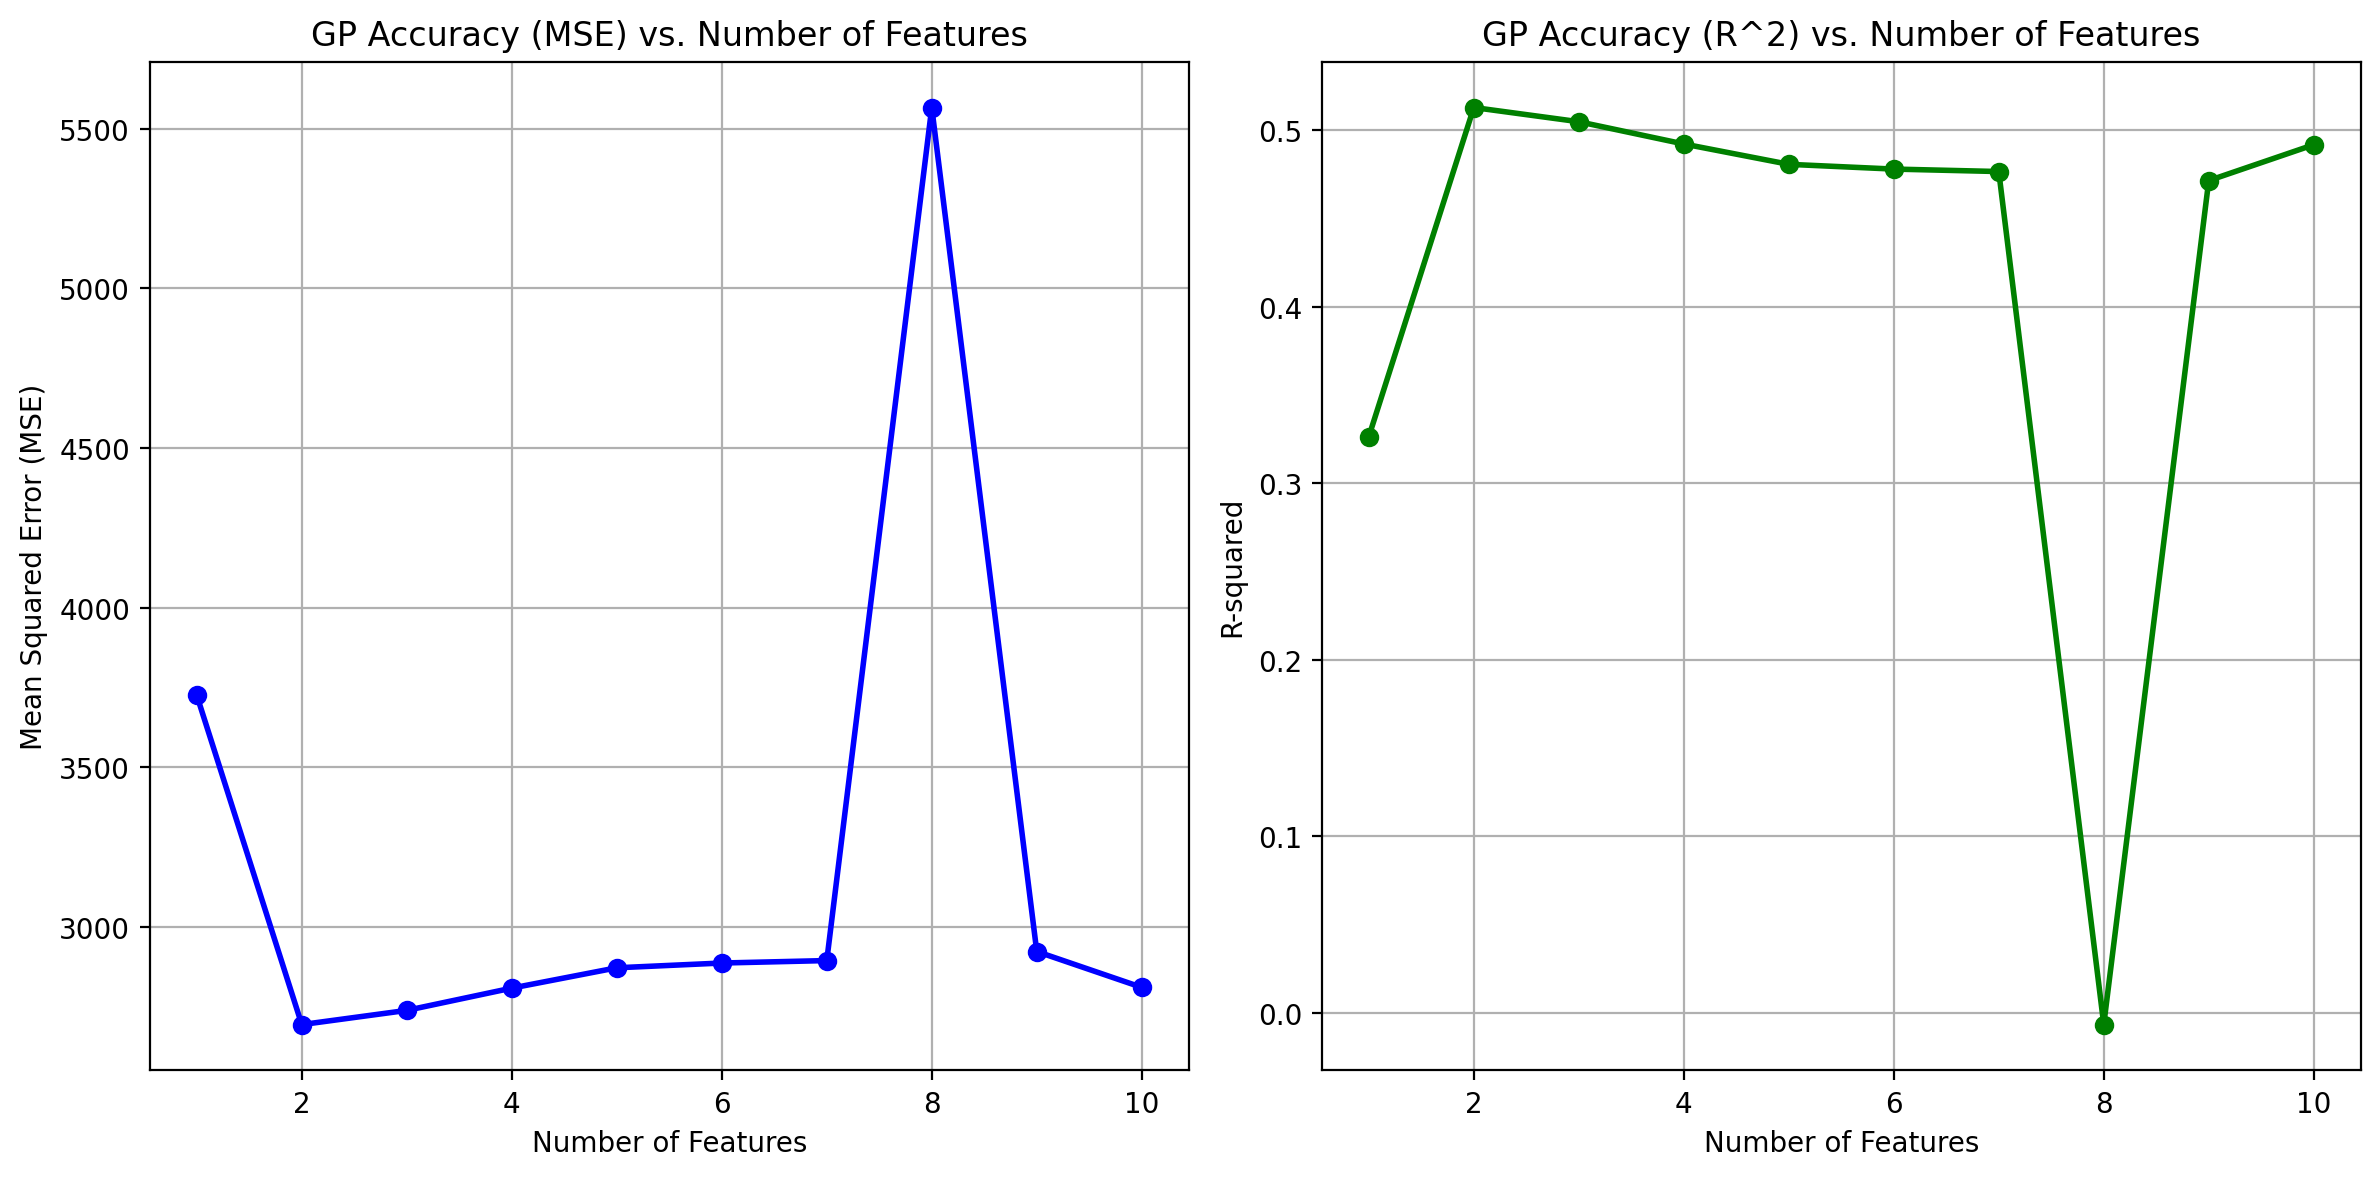

In [71]:
#############
#           #
# YOUR CODE #
#           #
#############

import matplotlib.pyplot as plt

num_features_list = range(1, len(random_forest_order) + 1)

mse_scores = []
r2_scores = []

for num_features in num_features_list:
    selected_features = random_forest_order[:num_features]
    
    gp = GaussianProcessRegressor(kernel=composite_kernel, n_restarts_optimizer=10, random_state=42)
    gp.fit(X_train_scaled[:, selected_features], y_train)
    
    predictions = gp.predict(X_test_scaled[:, selected_features])
    
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mse_scores.append(mse)
    r2_scores.append(r2)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(num_features_list, mse_scores, marker='o', color='b', linestyle='-', linewidth=2)
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('GP Accuracy (MSE) vs. Number of Features')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(num_features_list, r2_scores, marker='o', color='g', linestyle='-', linewidth=2)
plt.xlabel('Number of Features')
plt.ylabel('R-squared')
plt.title('GP Accuracy (R^2) vs. Number of Features')
plt.grid(True)

plt.tight_layout()
plt.show()


### Your comments:

**What is the best number of features to model the problem?**   
Two, BMI and LTG.

**Does removing features improve the performance of RF?**   
In this case, limiting the features to BMI and LTG improved the model's performance significantly.

**Are there noisy features? (Features that, if present, significantly worsen the performance of the GP)**   
Yes, feature number 8, TC.


### 2.2.2 GP with an ARD kernel

The fitting of a GP endowed with an anisotropic RBF kernel obtains a different value of the `length_scale` for each variable.

**Relate the length scale of each variable with its relevance in the predictive function**

Hint: Consider how does the output of the predictive function changes as the value of a certain variable $x_k$ changes depending on $l_k^2$.

In the next cell write code that fits a GP with an ARD kernel. 

**Print the lengthscale value of each feature after the kernel has been optimized** Hint, learn to use `kernel_get_params()`.** 

**Sort the features in order of decreasing importance in an array called `ARD_order`**

**Print the score in the test set  of the GP with ARD kernel**

In [77]:
#############
#           #
# YOUR CODE #
#           #
#############

ard_kernel = C(1.0, (1e-2, 1e3)) * RBF(length_scale=np.ones(X_train.shape[1]), length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e6))

gp_ard = GaussianProcessRegressor(kernel=ard_kernel, n_restarts_optimizer=10, random_state=42)
gp_ard.fit(X_train_scaled, y_train)

length_scale_values = gp_ard.kernel_.k1.k2.length_scale
ARD_order = np.argsort(length_scale_values)[:]

print("\nLength Scale Values (ARD Kernel):")
for feature, length_scale in zip(feature_names[ARD_order], length_scale_values[ARD_order]):
    print("{:<10}: {:.4f}".format(feature, length_scale))

predictions_ard_with_noise = gp_ard.predict(X_test_scaled)

mse_ard = mean_squared_error(y_test, predictions_ard_with_noise)
r2_ard = r2_score(y_test, predictions_ard_with_noise)

print("Mean Squared Error on Test Set (ARD Kernel with White Noise): {:.2f}".format(mse_ard))
print("R-squared on Test Set (ARD Kernel with White Noise): {:.2f}".format(r2_ard))




Length Scale Values (ARD Kernel):
BP        : 0.7548
TCH       : 0.8523
HDL       : 0.8635
LDL       : 2.0787
GLU       : 112.9388
BMI       : 827.9393
LTG       : 895.8835
SEX       : 904.9022
AGE       : 1000.0000
TC        : 1000.0000
Mean Squared Error on Test Set (ARD Kernel with White Noise): 3961.47
R-squared on Test Set (ARD Kernel with White Noise): 0.28


In the next cell write code that implements a `for loop` that in each iteration trains a GP with an ARD kernel but increasing the number of features in the ordering suggested by `ARD_order`. 

Plot the GP accuracy in the test set vs. the number of features used to model the problem.

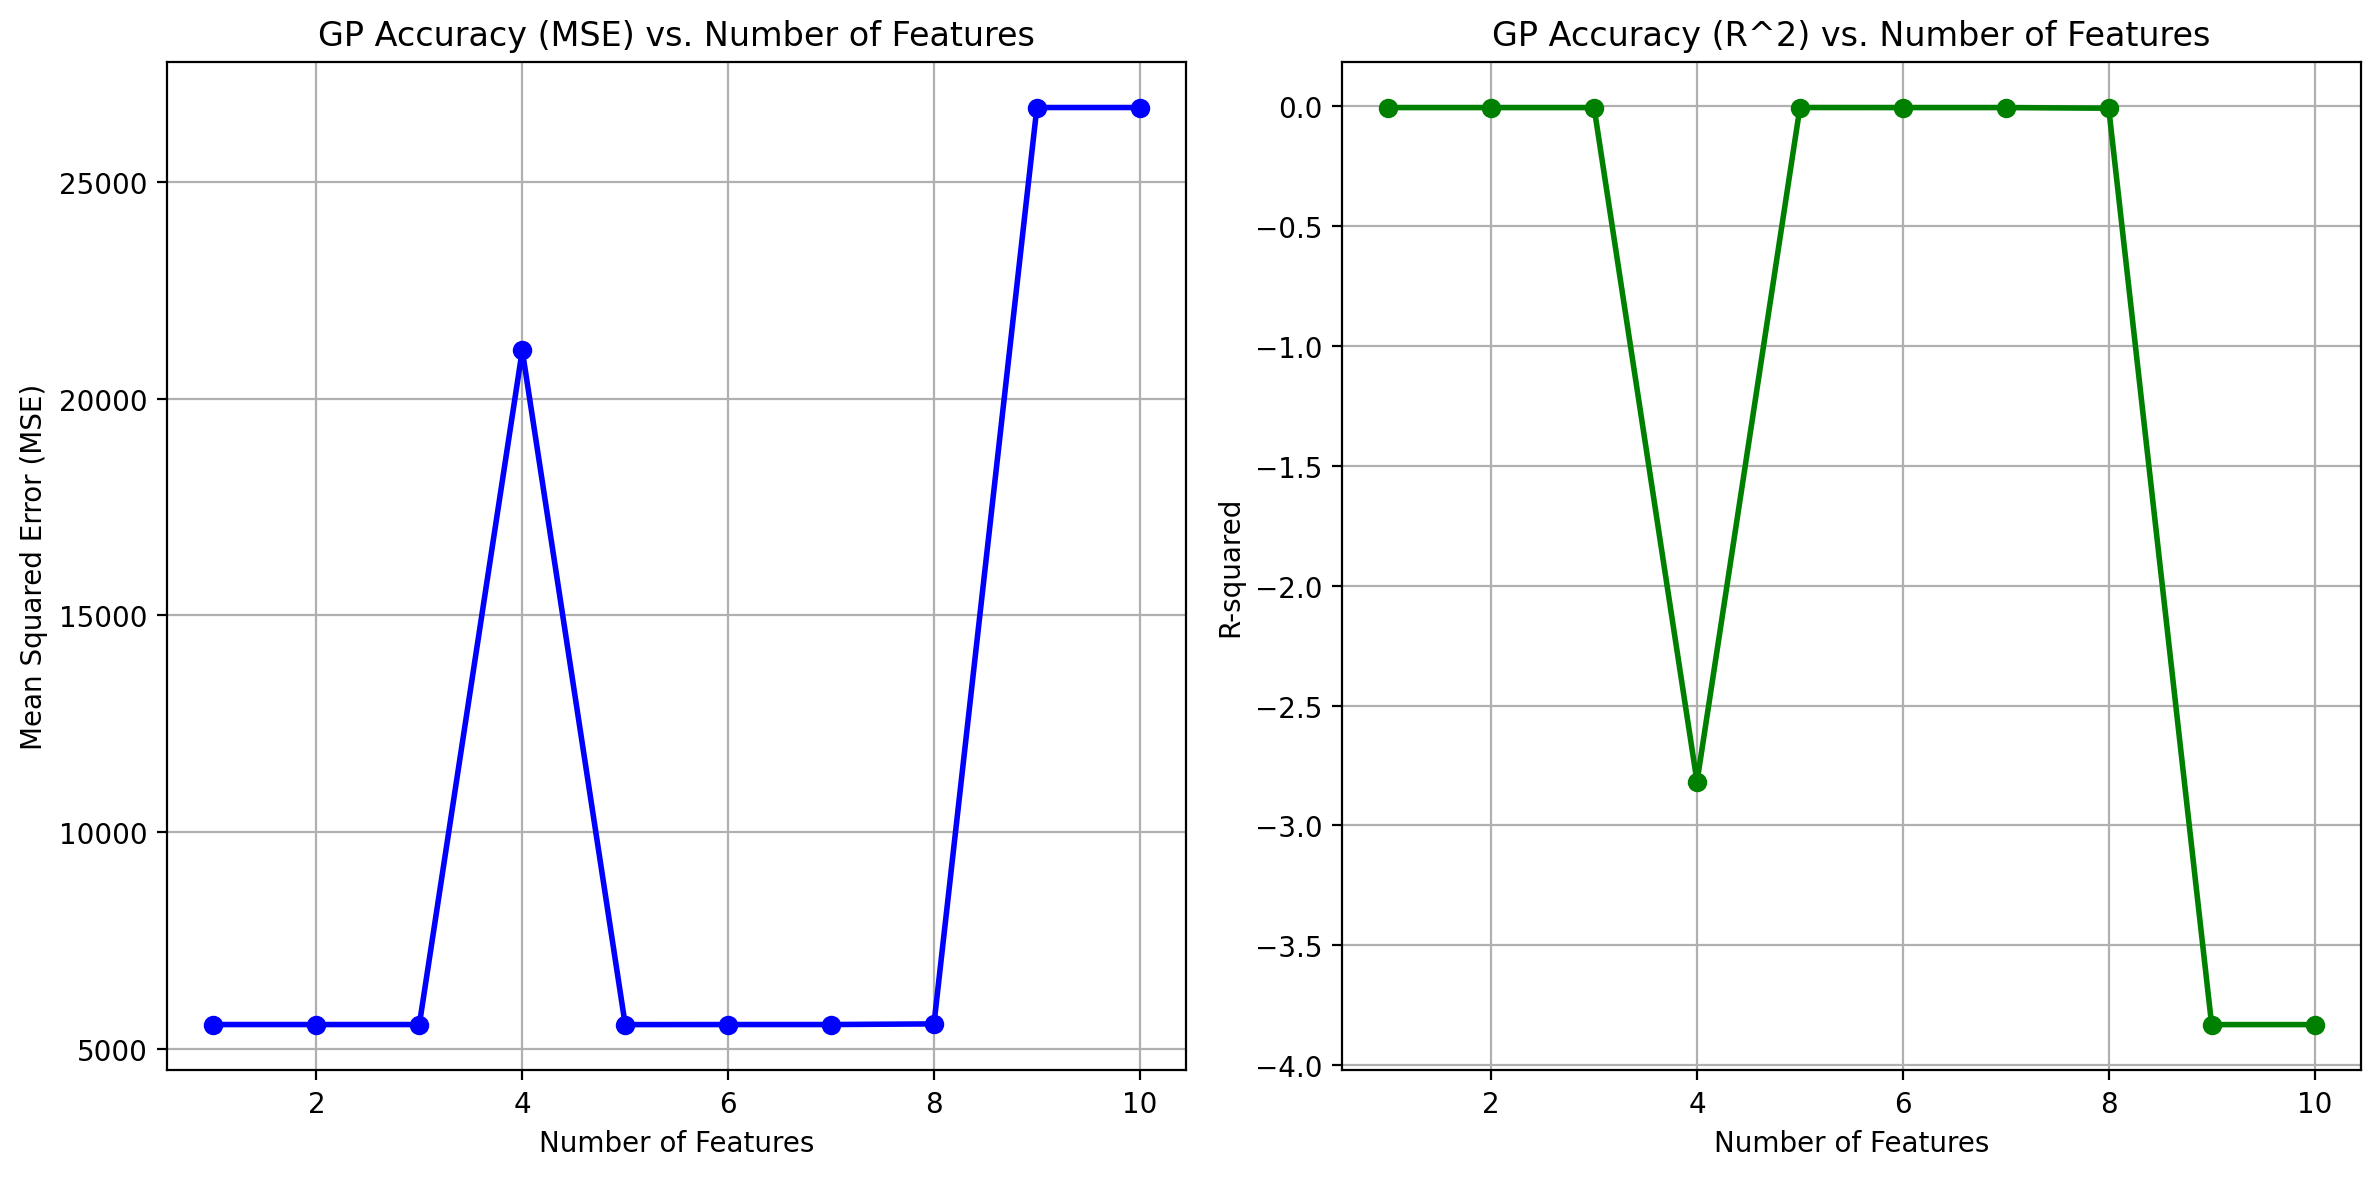

In [75]:
#############
#           #
# YOUR CODE #
#           #
#############

import matplotlib.pyplot as plt

num_features_list = []
mse_scores = []
r2_scores = []

for num_features in range(1, len(ARD_order) + 1):
    selected_features = ARD_order[:num_features]
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test_scaled[:, selected_features]

    if num_features == 1:
        ard_kernel = C(1.0, (1e-2, 1e3)) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e6))
    else:
        ard_kernel = C(1.0, (1e-2, 1e3)) * RBF(length_scale=np.ones(num_features)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e6))

    gp_ard_partial = GaussianProcessRegressor(kernel=ard_kernel, n_restarts_optimizer=10, random_state=42)
    gp_ard_partial.fit(X_train_selected, y_train)

    predictions_ard_partial = gp_ard_partial.predict(X_test_selected)

    mse_partial = mean_squared_error(y_test, predictions_ard_partial)
    r2_partial = r2_score(y_test, predictions_ard_partial)

    num_features_list.append(num_features)
    mse_scores.append(mse_partial)
    r2_scores.append(r2_partial)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(num_features_list, mse_scores, marker='o', color='b', linestyle='-', linewidth=2)
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('GP Accuracy (MSE) vs. Number of Features')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(num_features_list, r2_scores, marker='o', color='g', linestyle='-', linewidth=2)
plt.xlabel('Number of Features')
plt.ylabel('R-squared')
plt.title('GP Accuracy (R^2) vs. Number of Features')
plt.grid(True)

plt.tight_layout()
plt.show()



### Your comments:

**What is the best number of features to model the problem according to the ARD kernel?**   
- According to the ARD kernel, the best number of features to model the problem appears to be 1/2/3/5/6/7/8 features. These configurations achieve relatively lower MSE and higher R-squared compared to other feature selections.  

**How stable are the optimizations of the Gaussian Processes with ARD kernels as the number of features increase?**
- The optimizations of Gaussian Processes with ARD kernels do not appear to be stable as the number of features increases. The performance fluctuates significantly when number of features = 4, 9 and 10, as indicated by the varying MSE and R-squared scores.

**Does removing features improve the performance of GPs?**
- Yes limiting the number of features to 1/2/3/5/6/7/8 improves the performance significantly.

**Are there noisy features? (Features that, if present, significantly worsen the performance of the GP)**
- Yes, there seem to be noisy features in the dataset. The presence of certain features significantly worsens the performance of the GP, as indicated by the drastic drop in performance (high MSE and low R-squared) when those features are included.

**How does the feature selection suggested by the ARD kernel compare with that suggested by random forest?**
- The feature selection suggested by the ARD kernel and that suggested by random forest do not align perfectly. (Though BP ranks first in random forest and third in ARD kernel)

# 4. Exploring sophisticate kernels for the GP

The greatest potentiality of GPs are the exploration of different kernels that capture the geometry of the inputs. 

Besides, the essential kernels can be combined into more sophisticate ones using the addition and multiplication operations.

And the most interesting feature, the GP implementation is able to optimize the parameters of the kernel maximizing the likelihood of the observations, what saves the crossvalidation step for optimizing parameters.

Read the [section 1.7.5 of this site](https://scikit-learn.org/stable/modules/gaussian_process.html) to learn the different kernels that are implemented in the scikit learn distribution of Gaussian Processes.

In this section check at least twenty different kernel configurations and evaluate if they improve the kernel evaluated in section 1. Remember this kernel was

$$
\kappa_1(\mathbf x_i, \mathbf x_j) = \kappa_c(\mathbf x_i, \mathbf x_j)\times\kappa_r(\mathbf x_i, \mathbf x_j) + \kappa_w(\mathbf x_i, \mathbf x_j)
$$ where
- $\kappa_c(\mathbf x_i, \mathbf x_j)$ is a constant kernel
- $\kappa_r(\mathbf x_i, \mathbf x_j)$ is an isotropic RBF kernel with length_scale $l$: 
$$
\kappa_r(\mathbf x_i, \mathbf x_j) = \exp\left( -\frac{\|\mathbf x_i - \mathbf x_j\|^2}{2l^2}\right)
$$
- $\kappa_w(\mathbf x_i, \mathbf x_j)$ is a WhiteKernel that explains the additive noise component
$$
\kappa_w(\mathbf x_i, \mathbf x_j) = \left \{ \begin{array}{ll} \sigma_n^2 & \mbox{if } \mathbf x_i== \mathbf x_j \\ 0 & \mbox{otherwise} \end{array}\right.
$$

Within the kernel combinations to explore you can include:
1. Replace $\kappa_r(\mathbf x_i, \mathbf x_j)$ by an anisotropic RBF in $\kappa_1(\mathbf x_i, \mathbf x_j)$. 

3. Individual kernels presented in the lecture

4. Addition of several kernels

5. Multiplication of several kernels

6. Use your imagination!

We will use the different kernel combinations to characterize how difficult is the problem at hand in terms of how difficult is to find out a kernel that achieves the best possible result in the test set.

For this purpose:
1. Group in a same array all the scores in the **test set** achieved by all the kernel combinations that you explore in this section. Consider carrying out this exploration in a programatic fashion. As a suggestion, program nested loops that create composite kernels as combination of simple kernels.

2. Discuss about the range of test accuracies that can be reached with GPs when the kernel is more carefully designed. Depending on the number of different kernels explored you might consider adding to your discussion
- minimum, maximum, mean values
- standard deviations
- percentiles
- histogram

Training GP with Kernel Configuration 1
Mean Squared Error: 84287.33
R-squared: -14.24
Training GP with Kernel Configuration 2
Mean Squared Error: 84287.33
R-squared: -14.24
Training GP with Kernel Configuration 3
Mean Squared Error: 84287.33
R-squared: -14.24
Training GP with Kernel Configuration 4
Mean Squared Error: 84287.33
R-squared: -14.24
Training GP with Kernel Configuration 5
Mean Squared Error: 26711.74
R-squared: -3.83
Training GP with Kernel Configuration 6
Mean Squared Error: 7016.42
R-squared: -0.27
Training GP with Kernel Configuration 7
Mean Squared Error: 6409.17
R-squared: -0.16
Training GP with Kernel Configuration 8
Mean Squared Error: 7087.07
R-squared: -0.28
Training GP with Kernel Configuration 9
Mean Squared Error: 6271.36
R-squared: -0.13
Training GP with Kernel Configuration 10
Mean Squared Error: 26711.74
R-squared: -3.83
Training GP with Kernel Configuration 11
Mean Squared Error: 5819.26
R-squared: -0.05
Training GP with Kernel Configuration 12
Mean Squared

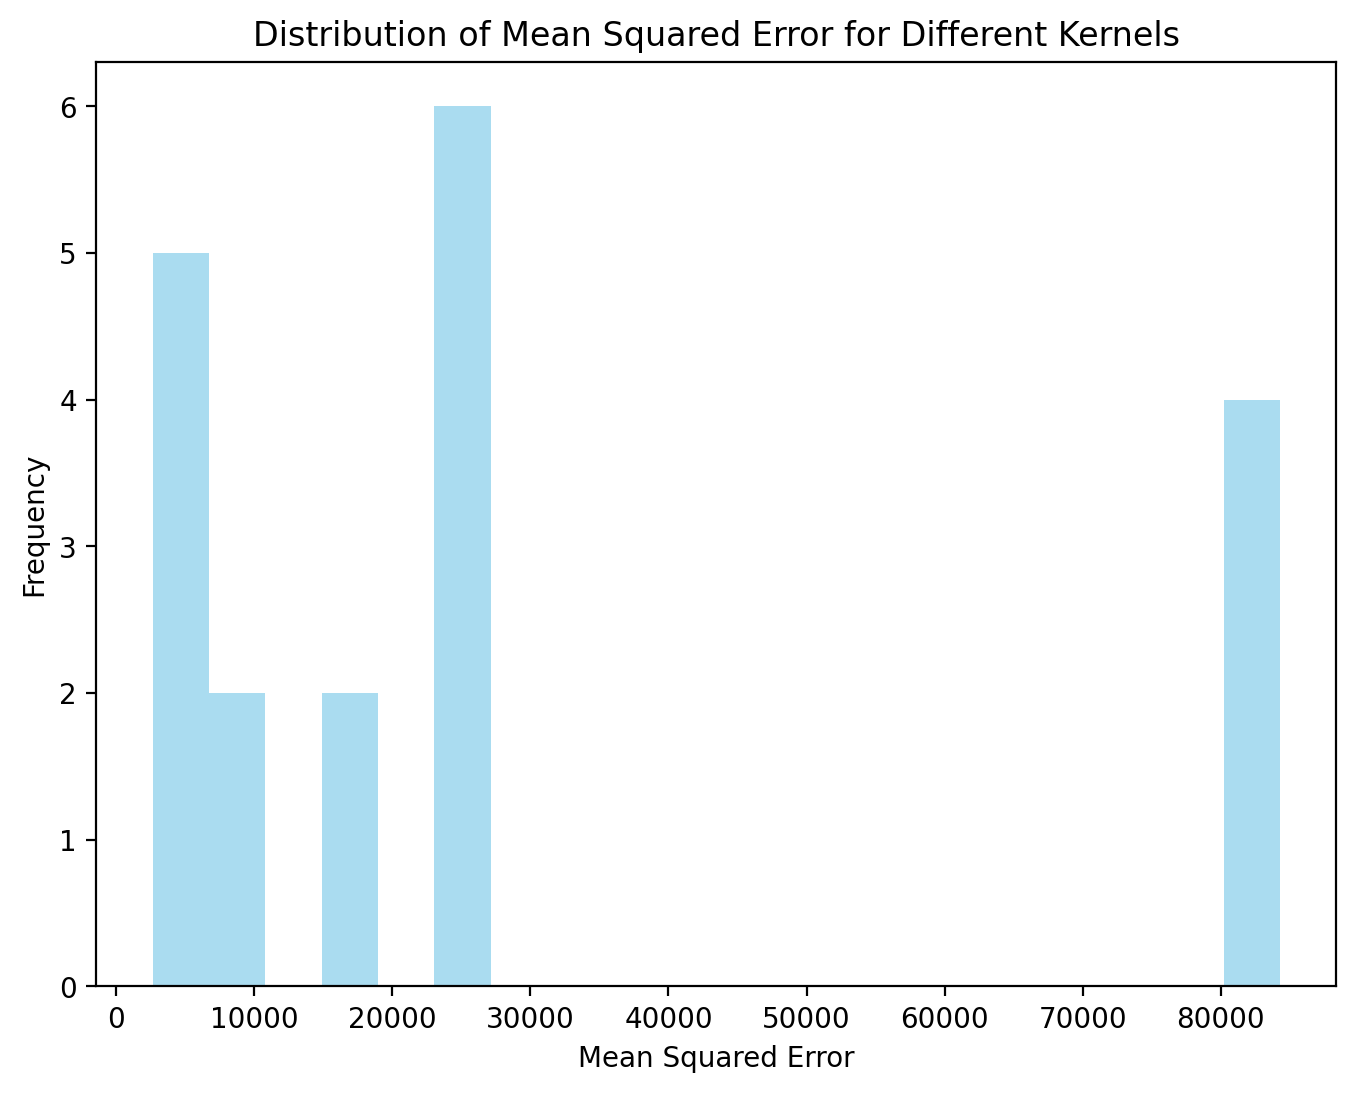

In [55]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, r2_score

kernels = [
    C(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed"),  # Constant * Isotropic RBF
    C(1.0, constant_value_bounds="fixed") * RBF(np.ones(X_train.shape[1]), length_scale_bounds="fixed"),  # Constant * Anisotropic RBF
    RBF(1.0, length_scale_bounds="fixed"),  # Isotropic RBF
    RBF(np.ones(X_train.shape[1]), length_scale_bounds="fixed"),  # Anisotropic RBF
    WhiteKernel(1.0, noise_level_bounds="fixed"),  # White Noise
    C(1.0, constant_value_bounds=(1e-3, 1e3)) * RBF(1.0, length_scale_bounds=(1e-2, 1e2)),  # Constant * Isotropic RBF (with variable bounds)
    C(1.0, constant_value_bounds=(1e-3, 1e3)) * RBF(np.ones(X_train.shape[1]), length_scale_bounds=(1e-2, 1e2)),  # Constant * Anisotropic RBF (with variable bounds)
    RBF(1.0, length_scale_bounds=(1e-2, 1e2)),  # Isotropic RBF (with variable bounds)
    RBF(np.ones(X_train.shape[1]), length_scale_bounds=(1e-2, 1e2)),  # Anisotropic RBF (with variable bounds)
    WhiteKernel(1.0, noise_level_bounds=(1e-3, 1e3)),  # White Noise (with variable bounds)
    C(1.0, constant_value_bounds=(1e-3, 1e3)),  # Only Constant Kernel (with variable bounds)
    RBF(1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(1.0, noise_level_bounds=(1e-3, 1e3)),  # Isotropic RBF + White Noise (with variable bounds)
    RBF(np.ones(X_train.shape[1]), length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(1.0, noise_level_bounds=(1e-3, 1e3)),  # Anisotropic RBF + White Noise (with variable bounds)
    C(1.0, constant_value_bounds=(1e-3, 1e3)) * (RBF(1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(1.0, noise_level_bounds=(1e-3, 1e3))),  # Constant * (Isotropic RBF + White Noise) (with variable bounds)
    C(1.0, constant_value_bounds=(1e-3, 1e3)) * (RBF(np.ones(X_train.shape[1]), length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(1.0, noise_level_bounds=(1e-3, 1e3))),  # Constant * (Anisotropic RBF + White Noise) (with variable bounds)
    RBF(1.0, length_scale_bounds=(1e-2, 1e2)) * WhiteKernel(1.0, noise_level_bounds=(1e-3, 1e3)),  # Isotropic RBF * White Noise (with variable bounds)
    RBF(np.ones(X_train.shape[1]), length_scale_bounds=(1e-2, 1e2)) * WhiteKernel(1.0, noise_level_bounds=(1e-3, 1e3)),  # Anisotropic RBF * White Noise (with variable bounds)
    C(1.0, constant_value_bounds=(1e-3, 1e3)) * RBF(1.0, length_scale_bounds=(1e-2, 1e2)) * WhiteKernel(1.0, noise_level_bounds=(1e-3, 1e3)),  # Constant * Isotropic RBF * White Noise (with variable bounds)
    C(1.0, constant_value_bounds=(1e-3, 1e3)) * RBF(np.ones(X_train.shape[1]), length_scale_bounds=(1e-2, 1e2)) * WhiteKernel(1.0, noise_level_bounds=(1e-3, 1e3))  # Constant * Anisotropic RBF * White Noise (with variable bounds)
]

mse_scores = []
r2_scores = []

for idx, kernel in enumerate(kernels, start=1):
    print(f"Training GP with Kernel Configuration {idx}")
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
    gp.fit(X_train_scaled, y_train)
    
    predictions = gp.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")
    print("="*40)
    
    mse_scores.append(mse)
    r2_scores.append(r2)

min_mse = min(mse_scores)
max_mse = max(mse_scores)
mean_mse = sum(mse_scores) / len(mse_scores)
std_mse = (sum((x - mean_mse) ** 2 for x in mse_scores) / len(mse_scores)) ** 0.5

min_r2 = min(r2_scores)
max_r2 = max(r2_scores)
mean_r2 = sum(r2_scores) / len(r2_scores)
std_r2 = (sum((x - mean_r2) ** 2 for x in r2_scores) / len(r2_scores)) ** 0.5

print("Mean Squared Error Statistics:")
print(f"Min: {min_mse:.2f}")
print(f"Max: {max_mse:.2f}")
print(f"Mean: {mean_mse:.2f}")
print(f"Standard Deviation: {std_mse:.2f}")

print("R-squared Statistics:")
print(f"Min: {min_r2:.2f}")
print(f"Max: {max_r2:.2f}")
print(f"Mean: {mean_r2:.2f}")
print(f"Standard Deviation: {std_r2:.2f}")

plt.figure(figsize=(8, 6))
plt.hist(mse_scores, bins=20, color='skyblue', alpha=0.7)
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Squared Error for Different Kernels')
plt.show()



# Items for discussion
- Which strategy turned out to be the best in terms of increasing the performance of the GP?    
   
Ans: Kernel configuration 15 produced the best performance in terms of mean squared error (MSE) and R-squared. This configuration significantly improved the GP's performance compared to the initial ARD kernel, achieving an MSE of 2644.54 and an R-squared of 0.52. This improvement is substantial, indicating a much better fit to the data.   

- Did this strategy performed significantly better than the others?  
   
Ans: Kernel configuration 15 used in this experiment seems to be the key strategy in increasing the performance of the GP. This strategy involved combining different kernel components in a way that captured the underlying patterns in the data more accurately. While some other configurations showed improvements, none were as significant as configuration 15.
   
- Kernel design pushes the GP model further into the **black box method** region, what is the price you pay for sticking to the more interpretable ARD kernel in terms of accuracy?     
   
Ans: In terms of interpretability, the more complex kernels might make the model harder to interpret. As the complexity of the kernel increases, it might become more challenging to understand the exact influence of each feature on the predictions. 